In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
%matplotlib inline

In [2]:
yelp = pd.read_csv("yelp_review_in_scope_dataset.csv")

In [3]:
yelp.shape

(70242, 9)

In [4]:
yelp.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",7/7/18 22:09
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,1/3/12 15:28
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2/5/14 20:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",1/4/15 0:01
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,1/14/17 20:54


In [5]:
yelp['text_length'] = yelp['text'].apply(len)
yelp.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",7/7/18 22:09,513
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,1/3/12 15:28,829
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2/5/14 20:30,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",1/4/15 0:01,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,1/14/17 20:54,534


Let’s visualise the data a little more by plotting some graphs with the Seabornlibrary.

Seaborn’s FacetGrid allows us to create a grid of histograms placed side by side. We can use FacetGrid to see if there’s any relationship between our newly created text length feature and the stars rating.

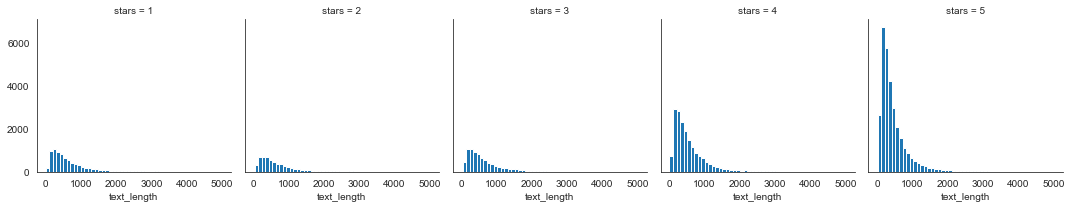

In [6]:
sns.set_style('white')
g = sns.FacetGrid(yelp, col = 'stars')
g.map(plt.hist, 'text_length', bins=50)

Seems like overall, the distribution of text length is similar across all five ratings. However, the number of text reviews seems to be skewed a lot higher towards the 4-star and 5-star ratings. This may cause some issues later on in the process.

Next, let’s create a box plot of the text length for each star rating.

<AxesSubplot:xlabel='stars', ylabel='text_length'>

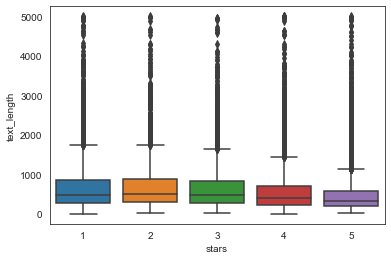

In [7]:
sns.boxplot(x='stars', y = 'text_length', data = yelp)

From the plot, looks like the 1-star and 2-star ratings have much longer text, but there are many outliers (which can be seen as points above the boxes). Because of this, maybe text length won’t be such a useful feature to consider after all.

<AxesSubplot:xlabel='stars', ylabel='count'>

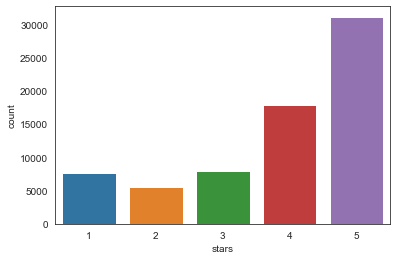

In [8]:
sns.countplot(x='stars', data=yelp)

Let’s group the data by the star rating, and see if we can find a correlation between features such as cool, useful, and funny. We can use the .corr()method from Pandas to find any correlations in the dataframe.

In [9]:
stars = yelp.groupby('stars').mean(numeric_only=True)
stars

,useful,funny,cool,text_length
stars,,,,
1,1.388424,0.432715,0.142932,676.857199
2,1.135860,0.370754,0.221845,678.713264
3,0.829608,0.289804,0.303616,644.218232
4,0.843110,0.250812,0.452368,561.694168
5,0.772719,0.185342,0.370620,460.766718


In [10]:
stars.corr()

,useful,funny,cool,text_length
useful,1.000000,0.946962,-0.882277,0.724350
funny,0.946962,1.000000,-0.884825,0.906916
cool,-0.882277,-0.884825,1.000000,-0.743605
text_length,0.724350,0.906916,-0.743605,1.000000


To visualise these correlations, we can use Seaborn’s heatmap:

<AxesSubplot:>

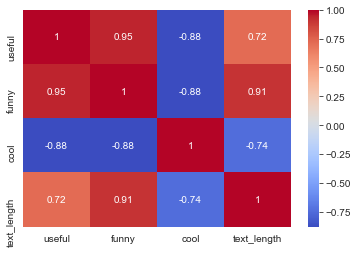

In [11]:
sns.heatmap(stars.corr(),cmap='coolwarm', annot=True)

Looking at the map, funny is strongly correlated with useful, and usefulseems strongly correlated with text length. We can also see a negative correlation between cool and the other three features.

<h1>Data Preprocessing</h1>

Data preprocessing is a crucial step which involves cleaning, transforming, and preparing raw textual data for analysis. We used a range of NLP techniques (as mentioned below) to prepare data that is suitable for the NLP algorithm to extract meaningful information.

Text Cleaning: We cleaned the data by removing irrelevant information, such as special characters and punctuation. We used regex match to perform this task.

Lower Casing: We converted the text to lowercase to ensure consistency. 

Tokenization: We performed the tokenization of the review. It is the process of breaking down text into individual units or words. We used the NLTK (Natural Language Toolkit) library in python for performing tokenization of the text review.

Stop Words Removal: Stop word removal is an important text preprocessing step that involves identifying and removing common or non-content words from the text data. These words (such as “the,” “and,”, “is”, "a" “an”) are often considered to have little or no meaning and contribute to noise in the data.

In [12]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]

    # Apply Porter Stemmer
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

<h1>Model building for Classification and Evaluation </h1>




<b>Feature Extraction: </b>
Feature extraction is an essential step in natural language processing (NLP) tasks, as it transforms raw textual data into a numerical representation that can be further processed by a classifier effectively. We used one of the most powerful feature extraction techniques, Term Frequency-Inverse Document Frequency (TF-IDF). We have utilized TF-IDF by importing TfidfVectorizer from scikit-learn library to vectorize the review text.

<b>Building and Training Model: </b>
Next we wanted to create a predictive mode model that can categorize the data points into predefined classes. For simplicity, we filtered the dataset to select the first 3000 reviews that had ratings of 1 or 5. Then we used 80% as training data and 20% as test data.We used the “text” feature for training and the “stars” feature as a label from our training dataset.
Next, we built a classifier model using four below machine learning algorithms and trained the model with the training dataset. Using this trained model, we were able to predict the star ratings of 1 or 5 for the review from the test dataset.

<b>Model Evaluation: </b>
After that We used Precision and Recall as the evaluation metric to measure our rating prediction performance. We compare our prediction with the star ratings to determine the correctness of our prediction.

<b>Classifier Evaluation with Visualization: </b>
Then We plotted a Bar chart to compare Accuracy, Precision and Recall of every classifier.

<b>Prediction with Unseen Review: </b>
Finally We have used two new unseen Yelp reviews to predict the star ratings using every classifier to understand its behavior.

Number of total samples: 3000

Support Vector Classifier Classifier (Based on Reviews):
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.78      0.85       104
           5       0.96      0.99      0.97       496

    accuracy                           0.95       600
   macro avg       0.95      0.88      0.91       600
weighted avg       0.95      0.95      0.95       600



Multinomial Naive Bayes Classifier (Based on Reviews):
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.18      0.31       104
           5       0.85      1.00      0.92       496

    accuracy                           0.86       600
   macro avg       0.90      0.59      0.61       600
weighted avg       0.87      0.86      0.81       600



Logistic Regression Classifier (Based on Reviews):
Accuracy: 0.

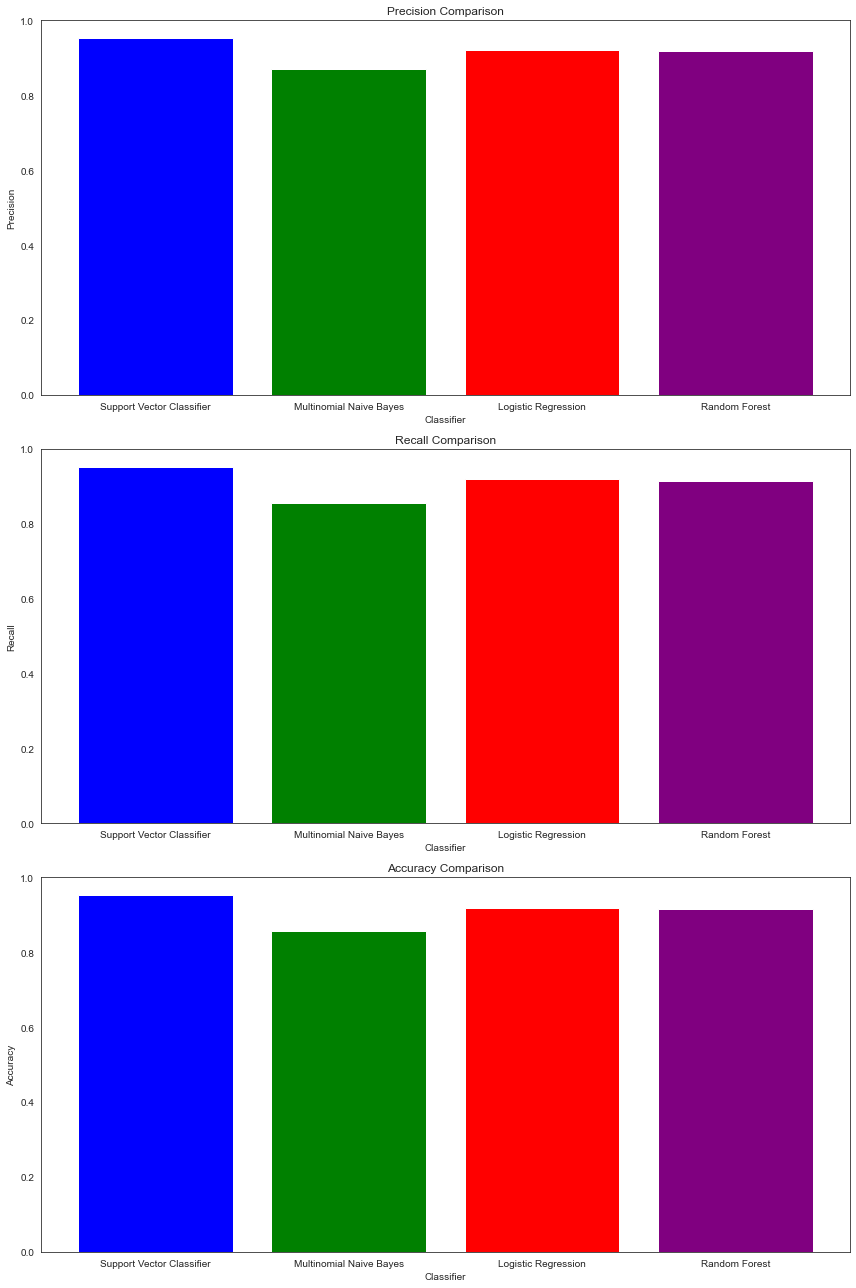

Support Vector Classifier Classifier Predictions (Based on Reviews):

Review:
 Horrible,  they have a scary mascot that scared my grandson and I asked him twice and my waitress for him not to come to our table.  Did he listen NO,kept coming back! Also served  a drink with a big crack! We will never return

Predicted Star Rating: 1

Actual Star Rating: 1

Review:
 Update after initial review:  ordered again last night using the yelp eat24 app. Food was ready within 10 minutes of placing the order. I opted for pickup since I was on my way home. The app did not give them my correct phone # and speaking to the great staff at the reception desk they told me sometimes yelp gets the addresses wrong for delivery so my advice is to type your phone # and address (if using delivery) into the comments box just so you get your food as fast as they intend to get it to you. 

This is the best place for sushi in the area. We have frequented other sushi places and this one by far stands above the rest.

In [13]:
# Take first 3000 rows
yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]
X = yelp_class['text'][:3000] 
y = yelp_class['stars'][:3000]
X = X.apply(preprocess_text)
print(f"Number of total samples: {len(X)}\n")

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers
classifiers = [
    ('Support Vector Classifier', SVC(kernel='linear', C=1)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier())
]

# Initialize lists to store metrics
precision_scores = []
recall_scores = []
accuracy_scores = []

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    print(f"{name} Classifier (Based on Reviews):")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

# Plot metrics in a bar chart
labels = [classifier[0] for classifier in classifiers]
metrics = ['Precision', 'Recall', 'Accuracy']

plt.figure(figsize=(12, 18))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    plt.bar(labels, [precision_scores[j] if metric == 'Precision' else recall_scores[j] if metric == 'Recall' else accuracy_scores[j] for j in range(len(classifiers))], color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title(f'{metric} Comparison')
    plt.xlabel('Classifier')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()
    
# Example unseen review texts for classification, First 3000 rows were already used for training and testing
new_reviews = yelp_class.iloc[3008:3010]["text"].to_numpy()
actual_star_ratings = yelp_class.iloc[3008:3010]["stars"].to_numpy()

# Preprocess the new reviews
new_reviews_processed = [preprocess_text(review) for review in new_reviews]

# Vectorize the new reviews using the same TF-IDF vectorizer
new_reviews_tfidf = tfidf_vectorizer.transform(new_reviews_processed)

# Predict the star ratings of the new reviews using each classifier based on 'reviews'
for name, clf in classifiers:
    star_ratings = clf.predict(new_reviews_tfidf)
    print(f"{name} Classifier Predictions (Based on Reviews):\n")
    for review, predicted_rating, actual_rating  in zip(new_reviews, star_ratings, actual_star_ratings):
        print(f"Review:\n {review}\n")
        print(f"Predicted Star Rating: {predicted_rating}\n")
        print(f"Actual Star Rating: {actual_rating}\n")
    print("\n")

<h1>Conclusion </h1>

We found that Support Vector Classification (SVC) has a maximum accuracy of 95%.

With the prediction model, we were able to predict star ratings of the unseen review with accuracy up to 90%. Any business trying to understand the customer sentiments based on the star ratings for the given reviews, they will be able to use this tool with higher accuracy. It can help the business focus on the reasons causing the negative reviews and focus on the priorities on getting those negative experiences limited. Additionally they can further focus on engaging the customers with targeted promotional campaigns who give positive reviews.